In [1]:
import numpy as  np
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import animation

import warnings
warnings.filterwarnings("ignore")

In [2]:
def upwind(r,X,T,U_init,U_left):
    U = np.zeros((len(X),len(T)))
    U[:,0] = U_init
    U[0,:] = U_left
    for n in np.arange(len(T)-1):
        U[1:, n+1] = U[1:, n] - r*(U[1:, n] - U[0:-1,n])        
    return U
    
def Lax_Friedrichs(r,X,T,U_init,U_left,U_right):
    U = np.zeros((len(X),len(T)))
    U[:,0] = U_init
    U[0,:] = U_left
    U[-1,:]= U_right
    for n in np.arange(len(T)-1):
        U[1:-1,n+1] = 0.5*(U[2:,n]+U[:-2,n])-0.5*r*(U[2:,n]-U[:-2,n])
    return U   
    
def Lax_Wendroff(r,X,T,U_init,U_left,U_right):
    U = np.zeros((len(X),len(T)))
    U[:,0] = U_init
    U[0,:] = U_left
    U[-1,:]= U_right
    for n in np.arange(len(T)-1):
        U[1:-1,n+1]=U[1:-1,n]-0.5*r*(U[2:,n]-U[:-2,n])+0.5*r**2*(U[2:,n]-2*U[1:-1,n]+U[:-2,n])
    return U


def hopscotch(r,X,T,U_init,U_left,U_right):
    U = np.zeros((len(X),len(T)))
    U[:,0] = U_init
    U[0,:] = U_left
    for n in np.arange(len(T)-1):
        for i in np.arange(len(X)-2):
            if (n+i+1)%2==0:
                U[i+1,n+1] = U[i+1,n]-0.5*r*(U[i+2,n]-U[i,n])
        for i in np.arange(len(X)-2):
            if (n+i+1)%2!=0:
                U[i+1,n+1] = U[i+1,n]-0.5*r*(U[i+2,n+1]-U[i,n+1])
    return U
    
    
def Thomas(La, Mb, Uc, b):
    """
    Arguments:
        La -- [lower item for tri-diagonal matrix]
        Mb -- [mian item for tri-diagonal matrix]
        Uc -- [upper item for tri-diagonal matrix]
        b -- [AX = b, where A is the tri-diagonal matrix]
    """
    n = len(Mb)
    Uc[0] = Uc[0] / Mb[0]
    for i in range(1, n-1):
        Uc[i] = Uc[i] / (Mb[i] - La[i - 1] * Uc[i - 1])
    b[0] = b[0] / Mb[0]
    for i in range(1, n):
        b[i] = (b[i] - La[i-1]*b[i-1]) / (Mb[i] - La[i-1] * Uc[i-1])
    ls = list(range(n-1))[::-1]
    for i in ls:
        b[i] = b[i] - Uc[i]*b[i+1]        
    return np.array(b)    
    
def full_implicate(r,X,T,U_init,U_left,U_right):
    U = np.zeros((len(X),len(T)))
    U[:,0] = U_init
    U[0,:] = U_left
    U[-1,:]= U_right
    
    for n in range(len(T)-1):
        a = -0.5*r*np.ones((len(X)-3))#给出矩阵三条对角线的值
        b = np.ones((len(X)-2))
        C = 0.5*r*np.ones((len(X)-3))
        k = []
        for i in range(len(X)-2):
            k.append(U[i+1,n])

        k[0]  += 0.5*r*U[0,n+1]
        k[-1] -= 0.5*r*U[-1,n+1]#计算Ax=b中的b

        U[1:-1,n+1] = Thomas(a,b,C,k)
    return U

def Crack_Nicholson(r,X,T,U_init,U_left,U_right):

    U = np.zeros((len(X),len(T)))
    U[:,0] = U_init
    U[0,:] = U_left
    U[-1,:]= U_right    

    for n in range(len(T)-1):
        a = -0.25*r*np.ones((len(X)-3))
        b = np.ones((len(X)-2))
        C = 0.25*r*np.ones((len(X)-3))
        k = []
        for i in range(len(X)-2):
            k.append(U[i+1,n]-0.25*r*(U[i+2,n]- U[i,n]))

        k[0]  += 0.25*r*U[ 0,n+1]
        k[-1] -= 0.25*r*U[-1,n+1]
        U[1:-1,n+1] = Thomas(a,b,C,k)
    return U

In [3]:
methods = np.array(['upwind','Lax_Friedrichs','Lax_Wendroff','hopscotch',\
                      'full_implicate','Crack_Nicholson'])

In [4]:
def solve(r,X,T,U_init,U_left,U_right,method):
    if method == 'upwind':
        U = upwind(r,X,T,U_init,U_left)
    elif method == 'Lax_Friedrichs':
        U = Lax_Friedrichs(r,X,T,U_init,U_left,U_right)
    elif method == 'Lax_Wendroff':
        U = Lax_Wendroff(r,X,T,U_init,U_left,U_right)
    elif method == 'hopscotch':
        U = hopscotch(r,X,T,U_init,U_left,U_right)        
    elif method == 'full_implicate':
        U = full_implicate(r,X,T,U_init,U_left,U_right)        
    elif method == 'Crack_Nicholson':
        U = Crack_Nicholson(r,X,T,U_init,U_left,U_right)               
    return U   
       

In [5]:
[xl,xr] = [0,10]
[ti,tf] = [0,10]

# case 3
## f(x,t) = sin(2$\pi$(x-ct)),dt<dx/c
## r > 1

In [7]:
dx = 0.1
dt = 0.2
c  = 1
r  = c*dt/dx
print(dt,dx,r)

0.2 0.1 2.0


In [8]:
T = np.arange(ti, tf+dt, dt)
X = np.arange(xl, xr+dx, dx)

In [9]:
len(T),len(X)

(51, 101)

In [10]:
def analytic_function(x,t):
    return np.sin(2*np.pi*(x-c*t))

In [11]:
U_init = analytic_function(X,0)
U_left = analytic_function(xl,T)
U_right= analytic_function(xr,T)

In [12]:
tt,xx = np.meshgrid(T,X)
U_a = analytic_function(xx,tt)

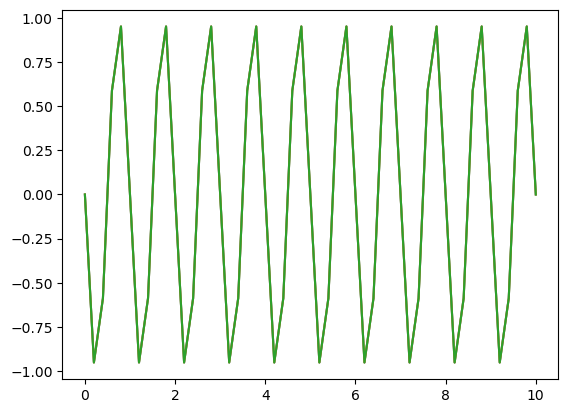

In [13]:
plt.plot(T,np.sin(2*np.pi*(1-c*T)))
plt.plot(T,analytic_function(1,T))
plt.plot(T,U_a[10,:])

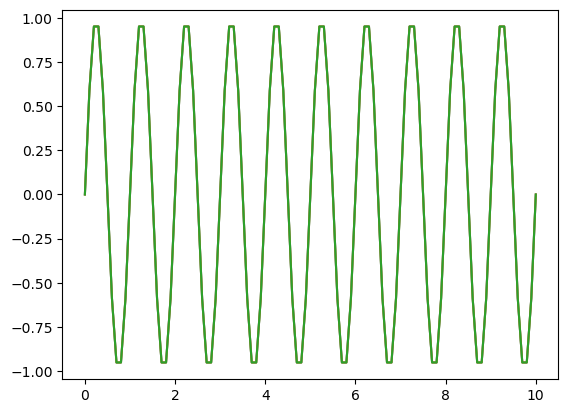

In [14]:
plt.plot(X,np.sin(2*np.pi*(X-c*10)))
plt.plot(X,analytic_function(X,10))
plt.plot(X,U_a[:,-1])

MovieWriter ffmpeg unavailable; using Pillow instead.


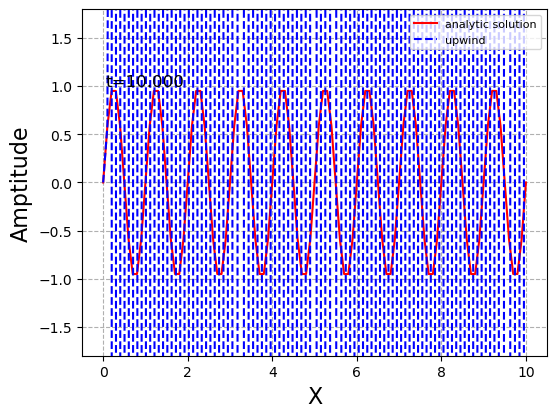

MovieWriter ffmpeg unavailable; using Pillow instead.


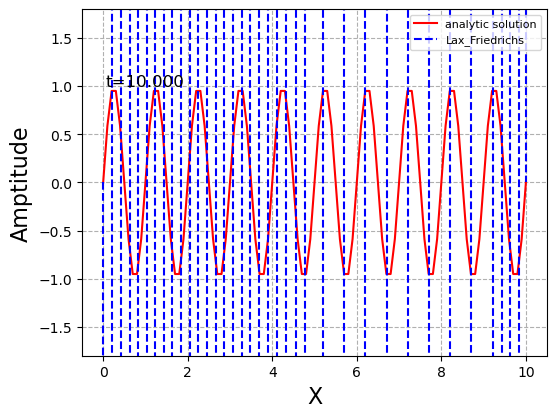

MovieWriter ffmpeg unavailable; using Pillow instead.


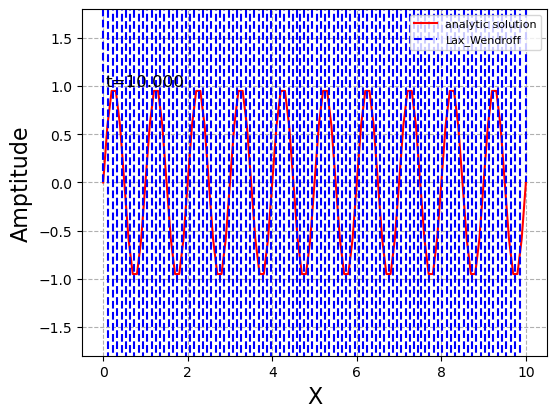

MovieWriter ffmpeg unavailable; using Pillow instead.


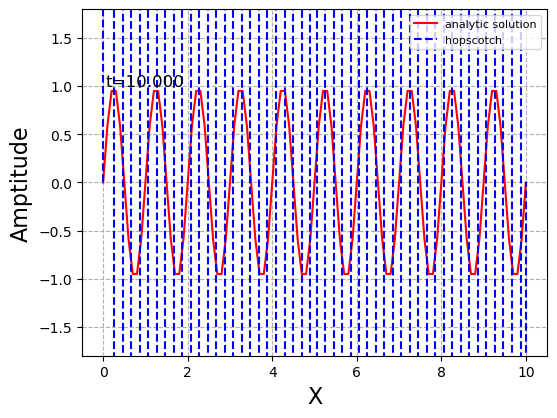

MovieWriter ffmpeg unavailable; using Pillow instead.


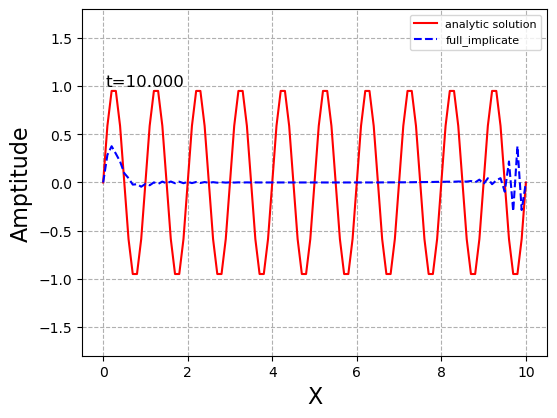

MovieWriter ffmpeg unavailable; using Pillow instead.


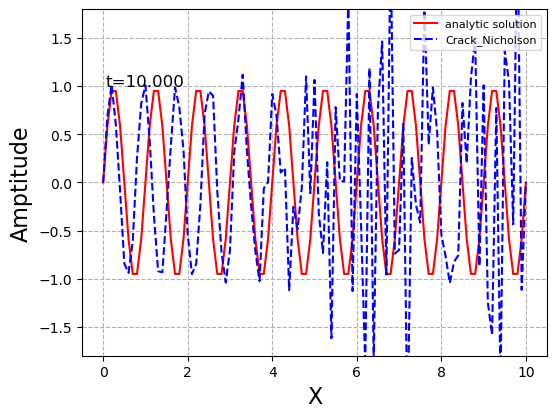

In [15]:
for m, method in enumerate(methods):
    
    U_n = solve(r,X,T,U_init,U_left,U_right,method)
    
    fig = plt.figure(figsize = (6,4.5),dpi=100)
    plt.grid(ls='--')
    ani_a, = plt.plot(X,U_a[:,0],color='red', ls='-' ,label='analytic solution')
    ani_n, = plt.plot(X,U_n[:,0],color='blue',ls='--',label=method)
    plt.xlabel("X", fontsize = 16)
    plt.ylabel("Amptitude", fontsize = 16)
    plt.legend(loc='upper right',fontsize=8)
    text_ani = plt.text(0.05, 1, '',fontsize=12,color='black')
    plt.ylim(-1.8,1.8)

    def update(n):
        ani_a.set_data(X,U_a[:,n])
        ani_n.set_data(X,U_n[:,n])
        ti = dt*n
        text_ani.set_text('t=%.3f'%ti)
        return [ani_a,ani_n,text_ani]
    ani = animation.FuncAnimation(fig=fig, func = update, frames = np.arange(0,len(T)), interval = 100)
    ani.save('image/case3/'+method+'.gif')
    plt.show()   
    